## Regularization: application with medical microbiology diagnosis
Name:  Maroua Hibatollah AABOUD 

We want to predict the IBD (Inflammatory Bowel Disease) clinical status of patients **given the abundance of microbial species** living in their gut.

Each patient is assigned to a clinical status, and the abundances of known species in their gut are reported in a matrix of size `patient x species`.

We focus here on the seminal metagenomic study by Nielsen H.B. et al, published in 2014.



In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

# Viz
import matplotlib.pyplot as plt

C:\Users\hibam\AppData\Local\Temp\ipykernel_15476\488321533.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the data
ab_data_pd = pd.read_csv("gut_abundances.tsv", sep="\t", header = 0)
descriptor_names = ab_data_pd.columns
ab_data = ab_data_pd.to_numpy()
status_txt =  pd.read_csv("ibd_status.lst", sep="\t", header = None).to_numpy()
ab_data_pd

,k__Bacteria,k__Archaea,k__Viruses,k__Bacteria|p__Bacteroidetes,k__Bacteria|p__Firmicutes,k__Bacteria|p__Proteobacteria,k__Bacteria|p__Actinobacteria,k__Archaea|p__Euryarchaeota,k__Bacteria|p__Verrucomicrobia,k__Viruses|p__Viruses_noname,...,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Leifsonia|s__Leifsonia_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Chromatiales|f__Ectothiorhodospiraceae|g__Thioalkalivibrio|s__Thioalkalivibrio_unclassified,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodobacterales|f__Rhodobacteraceae|g__Labrenzia|s__Labrenzia_unclassified,k__Viroids|p__Viroids_noname|c__Viroids_noname|o__Viroids_noname|f__Pospiviroidae|g__Pospiviroidae_noname|s__Dahlia_latent_viroid|t__PRJNA186953
MH0001,99.85542,0.12024,0.02435,75.76233,22.45185,0.79821,0.77138,0.12024,0.04902,0.02435,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0002,99.84094,0.00000,0.15906,29.66601,63.00964,0.80546,1.31857,0.00000,5.02320,0.15906,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0003,99.99769,0.00000,0.00231,28.89089,68.87499,1.10182,1.11216,0.00000,0.00000,0.00231,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0004,99.54958,0.44427,0.00615,36.82369,59.90264,0.96707,1.79713,0.44427,0.00000,0.00615,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MH0005,99.85338,0.02338,0.12324,53.45066,44.00230,0.66402,1.34265,0.02338,0.33886,0.12324,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V1_UC61_0,100.00000,0.00000,0.00000,73.60036,23.13241,1.97125,1.29598,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC62_0,99.43677,0.53534,0.02789,59.81443,31.16507,1.25950,7.12218,0.53534,0.07560,0.02789,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC7_0,99.97056,0.00000,0.02944,61.47615,31.97288,3.65580,1.59657,0.00000,1.25953,0.02944,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
V1_UC8_0,96.71485,3.21396,0.01313,26.64142,56.61496,0.68027,7.95935,3.21396,4.79898,0.01313,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Take a look at the data: number of samples ($n$), number of descriptors ($p$), names of descriptors (in ```descriptor_names```), etc.

In [3]:
n,p = ab_data.shape
print("Data shape:",n,p)

Data shape: 396 1939


We now transform the target variable to a binary (0 ==  control, 1 == IBD) variable ```status```:

In [4]:
status = np.ravel([int(s[0] == "IBD") for s in status_txt])

What is the name of the most correlated species (we denote by S) to the clinical status? Use the ```np.corrcoef``` function to compute the correlation between the data and the status.
You can compute the correlation between the data and the status using ```corr_vector = np.corrcoef(ab_data.transpose(),status)[:-1,p]```, which gives the correlation for each species.

In [8]:
corr_vector = np.corrcoef(ab_data.transpose(), status)[:-1,p]
max_corr_index = np.argmax(np.abs(corr_vector))
most_corr = descriptor_names[max_corr_index]

print("S =",most_corr)

S = k__Bacteria|p__Actinobacteria


Create a (naïve) predictor that takes as input the abundance of S and output the clinical status of the patient. Either compute the prediction accuracy or its AUC ROC for every threshold, this will be our baseline predictor to improve on.

(198, 1939)
(396, 1939)
index of best corr  704


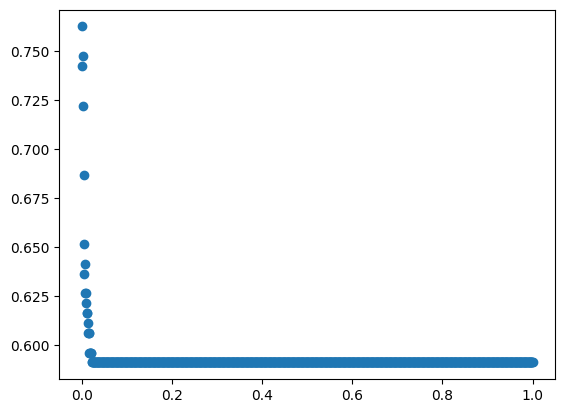

Accuracy on test set: 0.7272727272727273
AUC ROC on test set: 0.7012077019482739


In [40]:
# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(
    ab_data, status, test_size=0.5, shuffle=True, random_state=42
)
print(x_train.shape)
print(ab_data.shape)

# We remove species not abundant in the train set
col_to_rm = np.where(np.sum(x_train,axis=0) == 0)
x_train = np.delete(x_train,col_to_rm,axis=1)
x_test =  np.delete(x_test,col_to_rm,axis=1)
n,p = x_train.shape

# Index of the best correlated species to patient's status
best_cor_sp = np.argmax(np.abs(np.corrcoef(x_train.transpose(), y_train)[:-1,p]))
print("index of best corr ",best_cor_sp)

# Compute accuracy 
accuracy = list()
ths = np.linspace(0,int(np.max(x_train[:,best_cor_sp]))+1,1000) # threshold list
for t in ths:
    predictions = (x_train[:,best_cor_sp]>t)
    accuracy += [np.sum(predictions == y_train) / len(y_train)]
    
    
# Plot the decision threshold vs. performance of the predictor

plt.scatter(ths,accuracy)
plt.show()



# "Real" accuracy on test set
# Decision threshold corresponding to the best accuracy.
best_ths =  ths[np.argmax(accuracy)]
# Report the accuracy on the test set
predictions = (x_test[:, best_cor_sp] > best_ths)
accuracy_test = sum(predictions == y_test) / len(y_test)
print("Accuracy on test set:", accuracy_test)

roc = roc_auc_score(y_test==1, x_test[:, best_cor_sp])
print("AUC ROC on test set:",roc)


Now we hope that we can do better when using more than 1 descriptor.

We will first use a standard [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html ) function of Sklearn to evaluate your predictor in a cross-validation way.

Take a look at what metrics you can find in the attributes of the cross-validation object `cv` and print the average accuracy.

Do you gain in terms of accuracy compared to a single predictor? Check if you are overfitting the data.

In [22]:
logreg = linear_model.LogisticRegression(solver="liblinear", random_state=42)
cv = cross_validate(logreg, ab_data, status, cv=5, scoring='accuracy')

test_score = np.mean(cv['test_score'])
print("Average Cross-Validation accuracy on test:",test_score)


# Print example accuracy on 1 fold (fit with x_train and predict on x_test)
logreg.fit(x_train, y_train)
example_accuracy = logreg.score(x_test, y_test)
print("accuracy on 1 fold:", example_accuracy)
 

Average Cross-Validation accuracy on test: 0.7525632911392404
Example accuracy on 1 fold: 0.7525252525252525


Check the `coef_` attribute of your model. How many species are you using for taking the decision?

In [13]:
used_descriptors = used_descriptors = np.sum(np.abs(logreg.coef_) > 0)
print("The model uses ",used_descriptors,"descriptors")

The model uses  1632 descriptors


Considering that only few bacterial species may be responsible for IBD, choose a relevant regularization (see the available penalties for logistic regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



Now we hope that we can do better when using more than 1 descriptor.

We will first use a standard [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Use the [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html ) function of Sklearn to evaluate your predictor in a cross-validation way.

Take a look at what metrics you can find in the attributes of the cross-validation object `cv` and print the average accuracy.

Do you gain in terms of accuracy compared to a single predictor? Check if you are overfitting the data.

In [15]:
# Create a regularized model
logreg_regul = linear_model.LogisticRegression(solver="liblinear", random_state=42, penalty='l1')
logreg_regul.fit(x_train,y_train)
pred = logreg_regul.predict(x_test)

# Report accuracy on test set
accuracy = sum(pred == y_test) / len(y_test)
print("Accuracy on test set:", accuracy)


Accuracy on test set: 0.7676767676767676


Have you increased the accuracy? Looking at `logreg_regul.coef_`, how many descriptors are you using after regularization?
All things considered, is it a better model?

In [17]:
used_descriptors = np.sum(np.abs(logreg_regul.coef_) > 0)
print("We use",used_descriptors,"descriptors")

We use 108 descriptors


Remember that equivalent accuracy, but with fewer descriptors => more robust and explainable => better model !

Find the optimal regularization strength, by comparing performances on test set and train set. If you have more time, best is to do it by plotting the mean performance in cross-validation, with confidence enveloppe (+/- std deviation) over the folds.


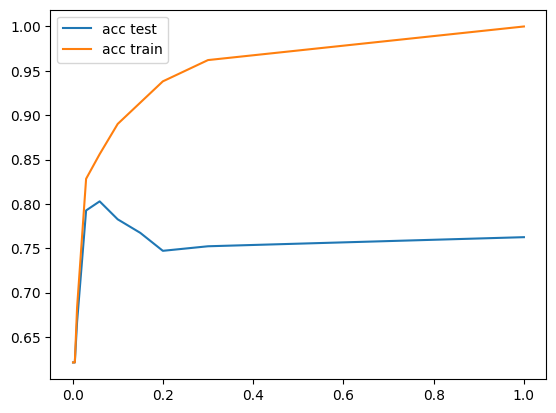

In [28]:
acc_test = list()
acc_train = list()


reg_strengths = [0.001,0.005,0.01,0.03,0.06,0.1,0.15,0.2,0.3,1]
for c in reg_strengths:
    logreg = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
    cv = cross_validate(logreg, x_train, y_train, return_train_score=True)
    acc_test.append(np.mean(cv['test_score']))
    acc_train.append(np.mean(cv['train_score']))
    
    
plt.clf()
plt.plot(reg_strengths,acc_test, label='acc test')
plt.plot(reg_strengths,acc_train, label='acc train')
plt.legend()
plt.show()

Train a classifier on the full dataset with the optimial regularization strength, and interpret the coefficients. You can check in particular if it is consistent with [this paper](https://pubmed.ncbi.nlm.nih.gov/27999802/) and [this one](https://pubmed.ncbi.nlm.nih.gov/20648002/).

In [38]:
# c is the optimal penalty given the previous graph (hard-code this number)
c = 0.01
logreg = linear_model.LogisticRegression(solver='liblinear', C=c)
logreg.fit(ab_data,status)

# positive association IBD, you can make use of numpy argsort function
order = np.argsort(logreg.coef_[0])[::-1]
order = order.tolist()
print(np.array(descriptor_names)[order[0]][:3])

# negative association with IBD
print(np.array(descriptor_names)[order[0]][-3:])



k__
mes


## Optional: other classifiers

Use other models for supervised classification (decision trees, SVM, neural nets, etc.) with the IBD data. Evaluate properly the performances, and pay attention to regularization!

